In [1]:
%matplotlib widget
%load_ext autoreload
%autoreload 2
%load_ext snakeviz
# dont forget to forward ports: ssh -L 8080:127.0.0.1:8080 sima9999@makalu47.rz.tu-ilmenau.de

import sys
import logging
sys.path.append("/usr/wrk/people9/sima9999/code/")
sys.path.append("/vegas/users/staff/womo1998/Projects/2019_OMA_UQ/code/")
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import scipy.stats.qmc

import ray

from uncertainty.polymorphic_uncertainty import *
from uncertainty.data_manager import DataManager

%aimport -sys -logging -matplotlib -matplotlib.pyplot -numpy -pandas - scipy.stats -scipy.stats.qmc

### Verification example: numerical modal analysis ###

System: Vibrating beam, hinged and flexibly supported
Input parameters and uncertainties:
- Cross-sectional area properties: polymorphic - e.g. due to manufacturing tolerances 
    - ellipse radius $a=0.9$: deterministic (to reduce dimension of design space)
    - ellipse radius $b$: imprecision
        - [0.85 ... 0.95] m deformed state; m=1
    - Wall thickness $t$: mixed - imprecision & variability
        - [5.9,6.1e-3] nominal; m=0.8
        - Normal(6e-3, 1e-4); m= 0.2

- Additional mass (plattforms, cables, antennas, etc.): imprecision
    - [0.2-1 kN/m Petersen: Stahlbau]

- Pre-tension of Guy wires: incompleteness -  due to unknown nominal state and variable temperature effects
    - Nominal state $\mu_N$ : mixed - deterministic & imprecision
        - 60000 N design value; m=0.75
        - [40000 - 180000] N; m=0.25
    - Normal($\mu_N$,2655) N; 
        -Standard deviation obtained from Geyer Monitoring Temperature Data with $N_\text{wire} = N_\text{nominal} - \alpha_t \Delta_t E A \cos^2(\alpha)$

- Cross-Sectional Area of wires: imprecision - due to manufacturing tolerances
    - [0.0007,0.0008] m; m=1

- Damping ratio: imprecision
    - [Petersen, 2017, P143] for low, medium, high vibration amplitudes: 
        - $\Lambda$=[0.008, 0.013, 0.018] (steel) + [0.035,0.04,0.06] (guyed masts) + [0.004,0.005,0.006] (concrete foundation)
        - $\zeta = \frac{\Lambda}{\sqrt{(2\pi)^2+\Lambda^2}} \approx \frac{\Lambda}{2\pi}$
    - VDI2038-2, Table 1, p. 14: $\zeta$=[0.0016, 0.015]
    - damping ratio [each m=0.3]: [0.0075, 0.0092],[0.0075, 0.0134], [0.0016, 0.015] 

- Viscosity of the TMD damper: incompleteness - due to unknown temperature-viscosity relations
    - Standard Deviation $\sigma_D$:
    - mean temp = 8.62, stdd temp = 8.19 (Geyer north sensor)
    - $F = \eta A   \frac{v}{h}$ ($\eta$: Viscosity, $A$ shear area, $v$ fluid velocity, $h$ height of the fluidlayer)
    - Daempfungskonstante: $\frac{F}{v} = \eta \frac{A}{h}$ [N s m^-2  m^2 m^-1 = N s m^-1]
    - $\eta = -6.23e-3 T + 8.45e-1$
    - $dD(T) = -1.557 T + 2.11e2$
    - $\sigma_{dD} = 12.75$
        - (10,15) N s m^-1; m=0.8
        - (0,25) N s m^-1; m=0.2
    - Normal(197.61, $\sigma_{dD}$)  N s m^-1
    
- Icing: incompletenes & variability & imprecision
     - probability of occurence: mixed - deterministic & imprecision 
         - [[28.2/365 = 0.077], [1/365, 77/365]] https://www.dwd.de/DE/wetter/wetterundklima_vorort/thueringen/erfurt/_node.html
    - occurence: variability
        - Bernoulli distribution
    - mass: imprecision
        - (EN DIN EN 1991-1-3/NA:2019-04: [0.5 - 1] kN/m )

- Young's Modulus $E$: deterministic 2.1e11 N/m^2
- mass density $\rho$: deterministic 7850 kg/m^3
- TMD mass $m$: deterministic 800 kg
- TMD stiffness $k_{y,z}$: deterministic 1025.48 N/m
- Degrees-of-freedom $n$: deterministic - 200
- number of modes considered $n_m$: deterministic - 14
- Sampling rate $f_s$: deterministic - 10 Hz
- Frequency lines $N$: deterministic - 1025
- Measurement locations $x_m$: deterministic - 5


    
Output parameters:
- damped modal frequencies: $f_{d,1} \ldots f_{d,14}$
- modal damping: $\zeta_1 \ldots \zeta_{14}$
- FRF (Magnitude) at length $x$ (also includes modeshapes) due to tip excitation: $\mathcal{H}_\mathrm{a}(\omega_\mathrm{f})$

In [2]:
from UQ_Modal_Beam import mapping_function, vars_definition

##### Uncertainty Modeling

In [3]:
vars_ale, vars_epi, arg_vars = vars_definition()
dim_ex = 'cartesian'

### Sampling

In [4]:
dim_ex = 'cartesian'
# %%snakeviz
N_mcs_ale = 13717 # N_mcs = 1e6 = N_mcs_ale * N_mcs_epi
N_mcs_epi = 729 # = 3^6 = 2.56^n_imp ~ 3^n_imp -> cover every corner and midpoints in a full-factorial design (but distributed)
use_dm = True
result_dir = '/usr/scratch4/sima9999/work/modal_uq/uq_modal_beam/'

poly_uq = PolyUQ(vars_ale, vars_epi, dim_ex=dim_ex)
if False:
    # seed 1165763483 scrambles adequately to achieve good discrepancy values even for few (100) samples
    poly_uq.sample_qmc(N_mcs_ale, N_mcs_epi, check_sample_sizes=False, seed=1165763483)
    poly_uq.save_state(os.path.join(result_dir,'polyuq_samp.npz'))
else:
    poly_uq.load_state(os.path.join(result_dir,'polyuq_samp.npz'))

if False:
    import seaborn as sns
    sns.pairplot(poly_uq.inp_samp_prim, kind='hist')

INFO:uncertainty.polymorphic_uncertainty:Now loading previous results from  /usr/scratch4/sima9999/work/modal_uq/uq_modal_beam/polyuq_samp.npz


### Propagation

In [ ]:
'''
blimits -l Batch72 
CPULIMIT                
4320.0 min of makalu101 -> 9 hrs @ 8 tasks -> 24 hrs @ 3 tasks -> 72 hrs @ 1 task
RUNLIMIT                
4800.0 min
TASKLIMIT               
512

FILELIMIT STACKLIMIT CORELIMIT MEMLIMIT PROCESSLIMIT
125500000 K  512000 K  100000 K  380000000 K    1000      
 
blimits -l Batch24 
CPULIMIT                
1440.0 min of makalu101 -> 6 hrs @ 4 tasks -> 24 hrs @ 1 task
TASKLIMIT               
512

FILELIMIT STACKLIMIT CORELIMIT MEMLIMIT PROCESSLIMIT
100000000 K  512000 K  100000 K  80000000 K     100   
 

blimits -l BatchXL 
TASKLIMIT               
4000

CORELIMIT MEMLIMIT PROCESSLIMIT THREADLIMIT
100000 K  256000000 K   16384        32768  

'''


if False:
    dm_grid,_, _ = poly_uq.to_data_manager('uq_modal_beam', 
                                        working_dir='/dev/shm/womo1998/', 
                                        result_dir=os.path.join(result_dir, 'samples'),
                                        overwrite=False)
elif True:
    dm_grid = DataManager.from_existing('uq_modal_beam.nc',
                                        result_dir=os.path.join(result_dir, 'samples'), 
                                        working_dir='/dev/shm/womo1998/')

# with dm_grid.get_database('out',rw=True) as out_ds:
#     out_ds['_runtimes'][:]=np.nan
    
# dm_grid.evaluate_samples(mapping_function, arg_vars, 
#                      ret_names={'damp_freqs':('modes',), 'zetas':('modes',), 'frf':('frequencies','space',)}, 
#                      default_len={'modes':14, 'frequencies':1025, 'space':2}, dry_run=False,
#                     chunks_submit=100000, chunks_save=15000, scramble_evaluation=False, re_eval_sample='1ddf809fb7f3_b5b3e888fca2')
eval_cost = 22 # seconds
num_workers = 440
sav_time= 800 # seconds
chunks_save = sav_time/eval_cost*num_workers # 16000 
todo = True
while todo:
    todo = dm_grid.evaluate_samples(mapping_function, arg_vars, 
                         ret_names={'damp_freqs':('modes',), 'zetas':('modes',), 'frf':('frequencies','space',)}, 
                         default_len={'modes':14, 'frequencies':1025, 'space':2}, dry_run=False,
                        chunks_submit=120000, chunks_save=20000, scramble_evaluation=False)

In [61]:
dm_grid = DataManager.from_existing('uq_modal_beam.nc',
                                result_dir=os.path.join('/dev/shm/womo1998/', 'testsamples'), 
                                working_dir='/dev/shm/womo1998/')
with dm_grid.get_database('out',False) as out_ds:
    out_ds_keep = out_ds.copy()
out_ds = out_ds_keep

In [ ]:
poly_uq = PolyUQ(vars_ale, vars_epi, dim_ex=dim_ex)
poly_uq.from_data_manager(None, 'frf', {'frequencies':1025, 'space':0}, out_ds)

### define output quantity

In [21]:
logger= logging.getLogger('uncertainty.polymorphic_uncertainty')
logger.setLevel(level=logging.INFO)

ret_name = ['damp_freqs','zetas','frf'][1]
if ret_name == 'frf':
    ret_ind = {'frequencies':105, 'space':5}
else:
    ret_ind = {'modes':8}
ret_dir = f'{ret_name}-{".".join(str(e) for e in ret_ind.values())}'
poly_uq = PolyUQ(vars_ale, vars_epi, dim_ex=dim_ex)
samp_path = os.path.join(result_dir,'polyuq_samp.npz')
prop_path = os.path.join(result_dir, 'estimations', f'{ret_dir}/polyuq_prop.npz')
imp_path = os.path.join(result_dir, 'estimations', f'{ret_dir}/polyuq_imp.npz')

### export from datamanager

In [ ]:

if True:
    poly_uq = PolyUQ(vars_ale, vars_epi, dim_ex=dim_ex)
    
    if os.path.exists(prop_path):
        continue

    for path in [imp_path, prop_path, samp_path]:
        if os.path.exists(path):
            poly_uq.load_state(path)

            poly_uq.from_data_manager(None, ret_name, ret_ind, out_ds)
            if ret_name == 'damp_freqs':
                poly_uq.out_valid = [np.nanmin(poly_uq.out_samp),np.nanmax(poly_uq.out_samp)]
            if path == samp_path:
                path = prop_path
            poly_uq.save_state(path)
            break
else:
    
    poly_uq.load_state(os.path.join(result_dir, 'estimations', f'{ret_dir}/polyuq_prop.npz'))

### Estimate imprecision

In [ ]:
if os.path.exists(imp_path):
    poly_uq.load_state(imp_path)
else:
    poly_uq.load_state(prop_path)
# %%snakeviz -t
logger= logging.getLogger('uncertainty.polymorphic_uncertainty')
logger.setLevel(level=logging.DEBUG)

# if poly_uq.imp_foc is not None:
#     start_ale = np.min(
#         np.nonzero(
#             np.any(
#                 np.isnan(poly_uq.imp_foc[:,:,0]),
#                 axis=1)
#         )[0]
#     )
# else:
#     start_ale = 0

start_ale = np.random.randint(3062,5402)
print(poly_uq.N_mcs_ale)
poly_uq.N_mcs_ale = start_ale + 1
poly_uq.estimate_imp(
        interp_fun='rbf',
        opt_meth='genetic',
        plot_res=True,
        plot_intp=False,
        intp_err_warn = 20,
        extrp_warn = 10,
        kernel='gaussian',
        start_ale = start_ale,
        epsilon={'frf':4,'zetas':2,'damp_freqs':2}[ret_name])
pass
# poly_uq.save_state(imp_path)

In [ ]:
plt.close('all')
for ret_name in ['damp_freqs','zetas','frf']:
    
    fig1, ax1 = plt.subplots()
    if ret_name == 'frf':
        # continue
        inds = range(1025*2)
    else:
        # continue
        inds = range(14)
    
    all_undershots = []
    num_undershots = []
    all_exceeds = []
    num_exceeds = []
    for ind in inds:
        if ret_name == 'frf':
            ret_ind = {'frequencies':ind//2, 'space':ind%2}
        else:
            ret_ind = {'modes':ind}
        ret_dir = f'{ret_name}-{".".join(str(e) for e in ret_ind.values())}'
        imp_path = os.path.join(result_dir, 'estimations', f'{ret_dir}/polyuq_imp.npz')
        prop_path = os.path.join(result_dir, 'estimations', f'{ret_dir}/polyuq_prop.npz')
        
        if not os.path.exists(imp_path): continue
        poly_uq.load_state(imp_path)
        
        if poly_uq.imp_foc is not None:
            samp_fin = np.nonzero(
                    np.any(
                        np.isnan(poly_uq.imp_foc[:,:,0]),
                        axis=1)
                )[0]
            print(samp_fin)
            if len(samp_fin)>0:
                start_ale = np.min(samp_fin)
            else:
                start_ale = poly_uq.N_mcs_ale
            print(start_ale)
        
        undershot = poly_uq.intp_undershot
        all_undershots.append(undershot[1] / undershot[0] / (poly_uq.out_valid[1]-poly_uq.out_valid[0])*100)
        all_undershots.append(0)
        num_undershots.append(undershot[0])
        num_undershots.append(poly_uq.N_mcs_ale*len(poly_uq.imp_hyc_foc_inds) - undershot[0])
        
        exceed = poly_uq.intp_exceed
        all_exceeds.append(exceed[1] / exceed[0] / (poly_uq.out_valid[1]-poly_uq.out_valid[0])*100)
        all_exceeds.append(0)
        num_exceeds.append(exceed[0])
        num_exceeds.append(poly_uq.N_mcs_ale*len(poly_uq.imp_hyc_foc_inds) - exceed[0])
        
        ax1.hist(100-poly_uq.intp_errors*100, bins=np.arange(101), alpha=0.1)
        
    ax1.set_title(ret_name + ' interpolator accuracy')

    plt.figure()
    plt.hist(all_undershots, weights= num_undershots, bins=50)
    plt.title(ret_name + ' undershot error')

    plt.figure()
    plt.hist(all_exceeds, weights= num_exceeds, bins=50)
    plt.title(ret_name + ' exceed error') 

### estimate incompleteness

In [30]:
def stat_fun(a, weight,i_stat):
    return np.average(a, weights=weight)
n_stat = 1
inc_path = os.path.join(result_dir, 'estimations', f'{ret_dir}/polyuq_avg_inc.npz')

# def stat_fun(a, weight, i_stat):
#     n = len(a)
#     mean = np.average(a, weights=weight)
#     std = np.sqrt(np.cov(a, aweights=weight))
#     if std==0:
#         conf= [mean, mean]
#     else:
#         sem = std / np.sqrt(n)
#         conf = scipy.stats.t.interval(alpha=0.95, df=n-1, loc=mean, scale=sem) 
#     if i_stat is not None:
#         return conf[i_stat]
#     else: 
#         return conf
# n_stat = 2
# inc_path = os.path.join(result_dir,'estimations', f'{ret_dir}/polyuq_ci_inc.npz')

In [31]:
if os.path.exists(inc_path):
    poly_uq.load_state(inc_path)
else:
    poly_uq.load_state(imp_path)

samp_fin = np.nonzero(
        np.any(
            np.isnan(poly_uq.imp_foc[:,:,0]),
            axis=1)
    )[0]
if len(samp_fin)>0:
    end_ale = np.min(samp_fin)
    poly_uq.N_mcs_ale = end_ale
focals_stats, hyc_mass = poly_uq.optimize_inc(stat_fun, n_stat)
poly_uq.save_state(inc_path)

INFO:uncertainty.polymorphic_uncertainty:Now loading previous results from  /usr/scratch4/sima9999/work/modal_uq/uq_modal_beam/estimations/damp_freqs-2/polyuq_imp.npz
INFO:uncertainty.polymorphic_uncertainty:Estimating incompleteness intervals by direct L-BFGS optimization of statistics over input hypercubes...
.

/usr/scratch4/sima9999/python/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2085: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/usr/wrk/people9/sima9999/code/uncertainty/polymorphic_uncertainty.py:1168: RuntimeWarning: invalid value encountered in divide
  p_weights[:, i_weight] /= np.sum(p_weights[:, i_weight])


...................................................................................................
INFO:uncertainty.polymorphic_uncertainty:Saving state of PolyUQ to /usr/scratch4/sima9999/work/modal_uq/uq_modal_beam/estimations/damp_freqs-2/polyuq_avg_inc.npz. Make sure to store your variable definitions script externally...


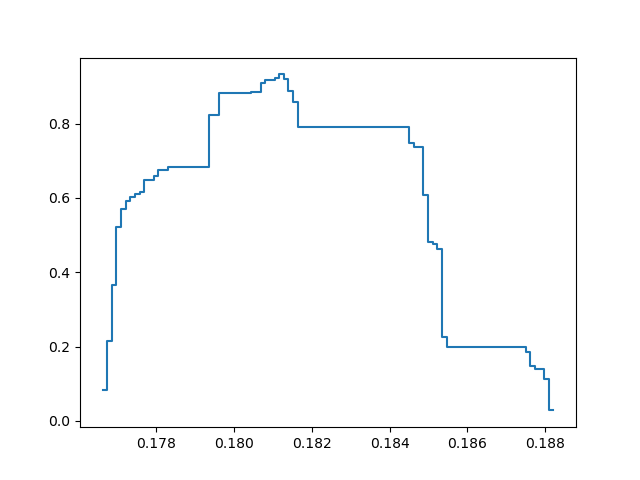

In [32]:
focals_stats, focals_mass = poly_uq.focals_stats, poly_uq.focals_mass
fig, ax1 = plt.subplots()
bel_stats, pl_stats, q_stats, bins_bel = aggregate_mass(focals_stats, hyc_mass, 10, False)
n_bins_bel = bins_bel.shape[0]
ax1.step(bins_bel, pl_stats[0], where='post',label='plausibility ')

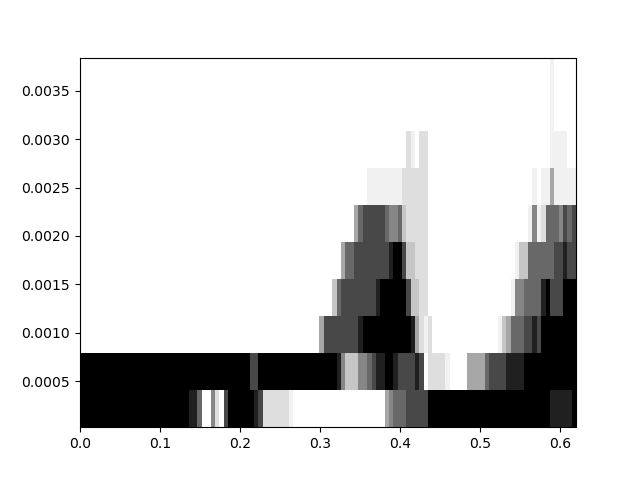

In [37]:
poly_uq = PolyUQ(vars_ale, vars_epi, dim_ex=dim_ex)
for ret_name in ['damp_freqs','zetas','frf']:
    if ret_name == 'frf':
        # continue
        #frequencies = np.arange(2048)
        all_focals = []
        space_ind = 1
        for freq_ind in range(127):
            ret_ind = {'frequencies':freq_ind, 'space':space_ind}
            ret_dir = f'{ret_name}-{".".join(str(e) for e in ret_ind.values())}'
            
            inc_path = os.path.join(result_dir,'estimations',f'{ret_dir}/polyuq_avg_inc.npz')
            if not os.path.exists(inc_path): continue
            arr = np.load(inc_path)
#             poly_uq.load_state(f'/usr/scratch4/sima9999/work/modal_uq/uq_modal/{ret_dir}/polyuq_avg_inc.npz')
            focals_stats, focals_mass = arr['self.focals_stats'], arr['self.focals_mass']
            all_focals.append(focals_stats)
            
        bel_stats, pl_stats, q_stats, bins_bel = aggregate_mass(np.stack([foc[0,:,:] for foc in all_focals]),focals_mass)
        n_bins_bel = bel_stats.shape[1]
        cmap = matplotlib.cm.get_cmap('Greys', n_bins_bel)
        plt.figure()
        im = plt.imshow(pl_stats.T, aspect='auto', extent= (0, 5/1025*127, np.min(focals_stats), np.max(focals_stats)),
                        cmap=cmap, origin='lower')
        
        
    else:
        continue
#         fig, (ax1,ax2) = plt.subplots(1,2,gridspec_kw={'width_ratios': [3, 1]}, sharey=True)
        fig, ax1 = plt.subplots()
            
        for mode_ind in range(14):
            ret_ind = {'modes':mode_ind}
            ret_dir = f'{ret_name}-{".".join(str(e) for e in ret_ind.values())}'
            
#             poly_uq.load_state(os.path.join(result_dir,'estimations',f'{ret_dir}/polyuq_lci_inc.npz'))
#             focals_stats, focals_mass = poly_uq.focals_stats, poly_uq.focals_mass
#             if False:
#                 plot_focals(focals_stats[0,:,:], focals_mass, ax2)
#             else:
#                 bel_stats, pl_stats, q_stats, bins_bel = aggregate_mass(focals_stats, focals_mass, 1, False)
#                 ax2.step(bins_bel, pl_stats[0], where='post',label='plausibility ')
            inc_path = os.path.join(result_dir,'estimations',f'{ret_dir}/polyuq_avg_inc.npz')
            if not os.path.exists(inc_path): continue
            poly_uq.load_state(inc_path)
            focals_stats, focals_mass = poly_uq.focals_stats, poly_uq.focals_mass
            
            if False:
                plot_focals(focals_stats[0,:,:], focals_mass, ax1)
            else:
                bel_stats, pl_stats, q_stats, bins_bel = aggregate_mass(focals_stats, focals_mass, 10, False)
                ax1.step(bins_bel, pl_stats[0], where='post',label='plausibility ')




            
# plt.step(bins_bel, bel_stats[0], where='post',label='belief')
# plt.step(bins_bel, bel_stats[1], where='post',label='belief')
# plt.step(bins_bel, pl_stats[0], where='post',label='plausibility ')
# plt.step(bins_bel, pl_stats[1], where='post', c='grey')
# plt.step(bins_bel, pl_stats[0], where='post', c='grey')
# plt.fill_between(bins_bel, pl_stats[0], pl_stats[1], step='post',label='plausibility', color='lightgrey')
# plt.step(bins_bel, q_stats[0], where='post',label='commonality')
# plt.legend()
# plt.xlabel(f"{ret_dir}")
# plt.ylabel("mass")
# None

In [ ]:
all_focals_this = np.stack([foc[0,:,:] for foc in all_focals])
# all_focals_this /= np.max(all_focals_this)
all_focals_this[all_focals_this<=1e-3] = 1e-3
all_focals_this[all_focals_this>80] = 80
# all_focals_this = 10*np.log10(all_focals_this)
bel_stats, pl_stats, q_stats, bins_bel = aggregate_mass(all_focals_this,focals_mass,1)
np.savez('/usr/scratch4/sima9999/frf_pl.npz', all_focals_this, bel_stats, pl_stats, q_stats, bins_bel)
n_bins_bel = bel_stats.shape[1]
cmap = matplotlib.cm.get_cmap('Greys', n_bins_bel)
with matplotlib.rc_context(print_context_dict2):
    plt.figure()
    print(np.min(all_focals_this), np.max(all_focals_this))
    im = plt.imshow(pl_stats.T, aspect='auto', extent= (0, 200, np.min(all_focals_this), np.max(all_focals_this)),
                    cmap=cmap, origin='lower', vmin=0, vmax=1)
    plt.xlabel('Frequency [\\si{\\hertz}]')
    plt.ylabel('FRF Magnitude [\\si{\\metre\\per\\second\\squared}]')

INFO:uncertainty.polymorphic_uncertainty:Now loading previous results from  /usr/scratch4/sima9999/work/modal_uq/uq_modal/omegans-0/polyuq_lci_inc.npz
INFO:uncertainty.polymorphic_uncertainty:Now loading previous results from  /usr/scratch4/sima9999/work/modal_uq/uq_modal/omegans-0/polyuq_avg_inc.npz
INFO:uncertainty.polymorphic_uncertainty:Now loading previous results from  /usr/scratch4/sima9999/work/modal_uq/uq_modal/omegans-0/polyuq_avg_inc.npz
INFO:uncertainty.polymorphic_uncertainty:Now loading previous results from  /usr/scratch4/sima9999/work/modal_uq/uq_modal/omegans-1/polyuq_avg_inc.npz
INFO:uncertainty.polymorphic_uncertainty:Now loading previous results from  /usr/scratch4/sima9999/work/modal_uq/uq_modal/omegans-2/polyuq_avg_inc.npz
INFO:uncertainty.polymorphic_uncertainty:Now loading previous results from  /usr/scratch4/sima9999/work/modal_uq/uq_modal/zetas-0/polyuq_avg_inc.npz
INFO:uncertainty.polymorphic_uncertainty:Now loading previous results from  /usr/scratch4/sima99

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
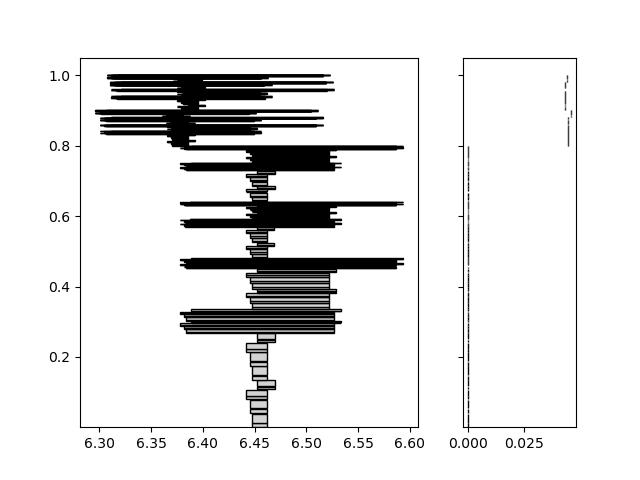

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
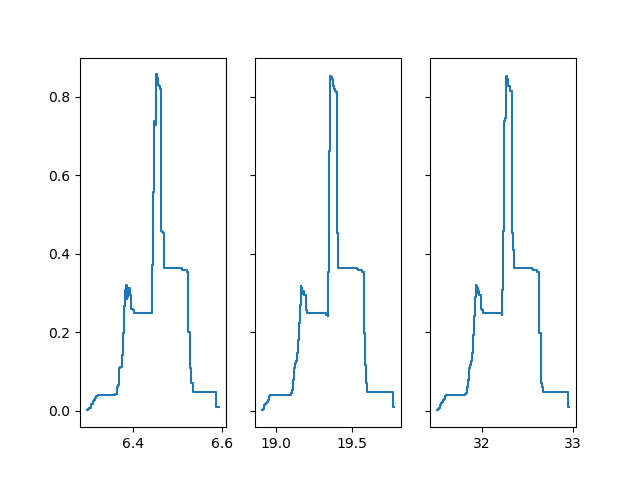

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
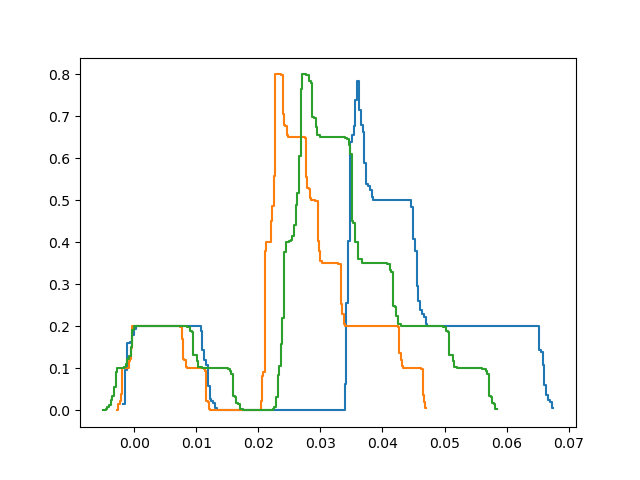

In [19]:
poly_uq = PolyUQ(vars_ale, vars_epi, dim_ex=dim_ex)

if 0:
    fig, (ax1,ax2) = plt.subplots(1,2,gridspec_kw={'width_ratios': [3, 1]}, sharey=True)
    ret_name='damp_freqs'
    ret_ind = {'modes':0}
    ret_dir = f'{ret_name}-{".".join(str(e) for e in ret_ind.values())}'
    poly_uq.load_state(os.path.join(result_dir,f'{ret_dir}/polyuq_lci_inc.npz'))
    focals_stats, focals_mass = poly_uq.focals_stats, poly_uq.focals_mass
    plot_focals(focals_stats[0,:,:], focals_mass, ax2)

    poly_uq.load_state(os.path.join(result_dir,f'{ret_dir}/polyuq_avg_inc.npz'))
    focals_stats, focals_mass = poly_uq.focals_stats, poly_uq.focals_mass
    plot_focals(focals_stats[0,:,:], focals_mass, ax1)
    
if 1:
    fig, axes = plt.subplots(1,3, sharey=True)
    ret_name='damp_freqs'
    for mode_ind,ax in enumerate(axes):
        ret_ind = {'modes':mode_ind}
        ret_dir = f'{ret_name}-{".".join(str(e) for e in ret_ind.values())}'
        poly_uq.load_state(os.path.join(result_dir,f'{ret_dir}/polyuq_avg_inc.npz'))
        focals_stats, focals_mass = poly_uq.focals_stats, poly_uq.focals_mass

        bel_stats, pl_stats, q_stats, bins_bel = aggregate_mass(focals_stats, focals_mass, 10, False)
        ax.step(bins_bel, pl_stats[0], where='post',label='plausibility')

if 1:
    fig, ax = plt.subplots(1,1, sharey=True)
    ret_name='zetas'
    for mode_ind in range(3):
        ret_ind = {'modes':mode_ind}
        ret_dir = f'{ret_name}-{".".join(str(e) for e in ret_ind.values())}'
        poly_uq.load_state(os.path.join(result_dir,f'{ret_dir}/polyuq_avg_inc.npz'))
        focals_stats, focals_mass = poly_uq.focals_stats, poly_uq.focals_mass

        bel_stats, pl_stats, q_stats, bins_bel = aggregate_mass(focals_stats, focals_mass, 10, False)
        ax.step(bins_bel, pl_stats[0], where='post',label='plausibility')

In [21]:
# ret_name = 'frf'
# space_ind = 9
# freq_ind = 100
# ret_ind = {'frequencies':freq_ind, 'space':space_ind}
ret_name = 'damp_freqs'
# ret_name = 'zetas'
mode_ind = 0
ret_ind = {'modes':mode_ind}

ret_dir = f'{ret_name}-{".".join(str(e) for e in ret_ind.values())}'
poly_uq = PolyUQ(vars_ale, vars_epi, dim_ex=dim_ex)

if True:
    poly_uq.load_state(os.path.join(result_dir,f'{ret_dir}/polyuq_imp.npz'))
    
    def stat_fun(a, weight, i_stat, bins_densities, cum_dens):
        '2. Quantify Variability for each incomplete sample and imprecise hypercube'
        if i_stat is None:
            hist,_ = np.histogram(a, bins_densities, weights=weight, density=True)

            if cum_dens:
                hist= np.cumsum(hist)
                hist /= hist[-1]   
            return hist
        else:
            # factor 6 faster but more error prone for "dirty" data, uneven bins or ....
            if cum_dens: first_edge = bins_densities[0]
            else: first_edge = bins_densities[i_stat]
            last_edge = bins_densities[i_stat + 1]
            keep  = (a >= first_edge)
            keep &= (a <=  last_edge)
            return np.sum(weight[keep])


    nbin_fact=20
    n_imp_hyc = len(poly_uq.imp_hyc_foc_inds)
    bins_densities = generate_histogram_bins(poly_uq.imp_foc.reshape(N_mcs_ale, n_imp_hyc * 2), 1, nbin_fact/2) # divide nbin_fact by 2 to account for reshaping intervals
    n_stat = len(bins_densities) - 1
    cum_dens = False
    stat_fun_kwargs = {'bins_densities':bins_densities, 'cum_dens':cum_dens}#, 'ax':ax1}

    # focals_densities, hyc_mass = poly_uq.estimate_inc(intervals, stat_fun, n_stat, stat_fun_kwargs)
    focals_stats, focals_mass = poly_uq.optimize_inc(stat_fun, n_stat, stat_fun_kwargs)
    # poly_uq.save_state(os.path.join(result_dir,f'{ret_dir}/polyuq_hist_inc.npz'))
else:
    poly_uq.load_state(os.path.join(result_dir,f'{ret_dir}/polyuq_hist_inc.npz'))
    
    nbin_fact=20
    n_imp_hyc = len(poly_uq.imp_hyc_foc_inds)
    bins_densities = generate_histogram_bins(poly_uq.imp_foc.reshape(N_mcs_ale, n_imp_hyc * 2), 1, nbin_fact/2) # divide nbin_fact by 2 to account for reshaping intervals
    cum_dens = True
    
    focals_stats = poly_uq.focals_stats
    focals_mass = poly_uq.focals_mass

INFO:uncertainty.polymorphic_uncertainty:Now loading previous results from  /usr/scratch4/sima9999/work/modal_uq/uq_modal/omegans-0/polyuq_imp.npz
INFO:uncertainty.polymorphic_uncertainty:Estimating incompleteness intervals by direct L-BFGS optimization of statistics over input hypercubes...


/usr/wrk/people9/sima9999/my-python/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:579: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx


....................................................................................................


In [24]:
focals_stats = focals_densities
focals_mass = hyc_mass
bel_densities, pl_densities, q_densities, bins_bel = aggregate_mass(focals_stats, focals_mass, 20, False)
n_bins_bel = bel_densities.shape[1]

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
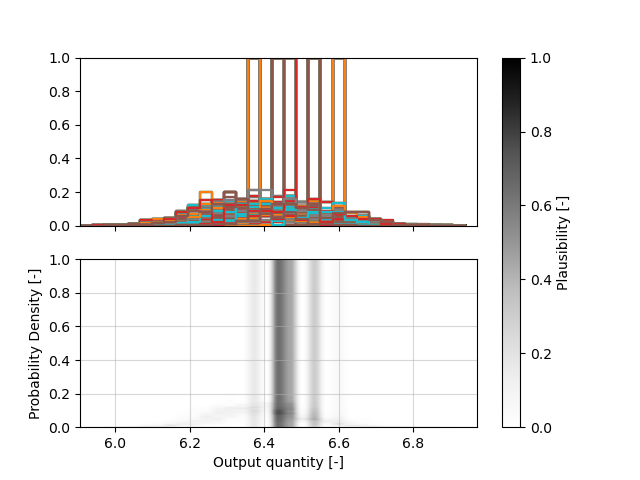

In [25]:

bpq=2

fig, (ax1, ax2) = plt.subplots(2,1,sharex=True,sharey=True)   

for i_hyc in range(hyc_mass.shape[0]):
    l2d=ax1.step(bins_densities[:-1], focals_stats[:,i_hyc, 0], where='post')
    c = l2d[0].get_color()
    ax1.step(bins_densities[:-1], focals_stats[:,i_hyc, 1], where='post', color=c)

if bpq == 1:
    belief = bel_densities.T
    label = 'Belief [-]'
elif bpq == 2:
    belief = pl_densities.T
    label = 'Plausibility [-]'
elif bpq == 3:
    belief = q_densities.T
    label = 'Commonality [-]'

cmap = matplotlib.cm.get_cmap('Greys', n_bins_bel)
im = ax2.imshow(belief, aspect='auto', extent= (bins_densities[0], bins_densities[-1], 0, 1), 
           cmap=cmap, origin='lower', vmin=0, vmax=1)

cbar = fig.colorbar(im, ax=[ax1,ax2])
cbar.set_label(label)

ax2.grid(True, alpha=0.5)
ax2.set_xlabel("Output quantity [-]")

if cum_dens:
    ax2.set_ylabel("Cumulative Probability Density [-]")
else:
    ax2.set_ylabel("Probability Density [-]")    

### distributed quantification (ray) ###

In [5]:
import ray
ray.init(address='auto', _redis_password='5241590000000000')

2022-10-19 08:14:30,344	INFO worker.py:825 -- Connecting to existing Ray cluster at address: 192.168.103.47:6379
[2022-10-19 08:14:30,349 I 5890 5890] global_state_accessor.cc:332: This node has an IP address of 141.24.193.47, while we can not found the matched Raylet address. This maybe come from when you connect the Ray cluster with a different IP address or connect a container.


{'node_ip_address': '141.24.193.47',
 'raylet_ip_address': '141.24.193.47',
 'redis_address': '192.168.103.47:6379',
 'object_store_address': '/usr/tmp/ray/session_2022-10-18_08-41-30_468459_19293/sockets/plasma_store',
 'raylet_socket_name': '/usr/tmp/ray/session_2022-10-18_08-41-30_468459_19293/sockets/raylet',
 'webui_url': '141.24.193.47:5990',
 'session_dir': '/usr/tmp/ray/session_2022-10-18_08-41-30_468459_19293',
 'metrics_export_port': 53712,
 'node_id': 'e5f4733793a8c3b862548df0c5e0d97b47cef2541dd1e82d14e887b0'}

In [6]:
@ray.remote
def remot_est_imp(ret_name, ret_ind):
    ret_dir = f'{ret_name}-{".".join(str(e) for e in ret_ind.values())}'

    poly_uq = PolyUQ(vars_ale, vars_epi, dim_ex=dim_ex)

    poly_uq.load_state(os.path.join(result_dir, 'estimations', f'{ret_dir}/polyuq_prop.npz'))

    poly_uq.estimate_imp(interpolate=True, opt_meth='Powell')
    poly_uq.save_state(os.path.join(result_dir, 'estimations', f'{ret_dir}/polyuq_imp.npz'))

In [7]:
@ray.remote
def remote_opt_inc(ret_name, ret_ind):
    
    def stat_fun_hist(a, weight, i_stat, bins_densities, cum_dens):
        '2. Quantify Variability for each incomplete sample and imprecise hypercube'
        if i_stat is None:
            hist,_ = np.histogram(a, bins_densities, weights=weight, density=True)

            if cum_dens:
                hist= np.cumsum(hist)
                hist /= hist[-1]   
            return hist
        else:
            # factor 6 faster but more error prone for "dirty" data, uneven bins or ....
            if cum_dens: first_edge = bins_densities[0]
            else: first_edge = bins_densities[i_stat]
            last_edge = bins_densities[i_stat + 1]
            keep  = (a >= first_edge)
            keep &= (a <=  last_edge)
            return np.sum(weight[keep])
    
    def stat_fun_avg(a, weight,i_stat):
        return np.average(a, weights=weight)

    def stat_fun_ci(a, weight, i_stat):
        n = len(a)
        mean = np.average(a, weights=weight)
        std = np.sqrt(np.cov(a, aweights=weight))
        if std==0:
            conf= [mean, mean]
        else:
            sem = std / np.sqrt(n)
            conf = scipy.stats.t.interval(alpha=0.95, df=n-1, loc=mean, scale=sem) 
        if i_stat is not None:
            return conf[i_stat]
        else: 
            return conf
        
    def stat_fun_lci(a, weight, i_stat):
        n = len(a)
        mean = np.average(a, weights=weight)
        std = np.sqrt(np.cov(a, aweights=weight))
        if std==0:
            conf= [mean, mean]
        else:
            sem = std / np.sqrt(n)
            conf = scipy.stats.t.interval(alpha=0.95, df=n-1, loc=mean, scale=sem) 
        return conf[1]-conf[0]

    
    ret_dir = f'{ret_name}-{".".join(str(e) for e in ret_ind.values())}'

    poly_uq.load_state(os.path.join(result_dir,'estimations', f'{ret_dir}/polyuq_imp.npz'))
    
    if False:
        nbin_fact=20
        n_imp_hyc = len(poly_uq.imp_hyc_foc_inds)
        bins_densities = generate_histogram_bins(poly_uq.imp_foc.reshape(N_mcs_ale, n_imp_hyc * 2), 1, nbin_fact/2) # divide nbin_fact by 2 to account for reshaping intervals
        n_stat = len(bins_densities) - 1
        cum_dens = True
        stat_fun_kwargs = {'bins_densities':bins_densities, 'cum_dens':cum_dens}#, 'ax':ax1}
        # focals_densities, hyc_mass = poly_uq.estimate_inc(intervals, stat_fun, n_stat, stat_fun_kwargs)
        focals_densities, hyc_mass = poly_uq.optimize_inc(stat_fun_hist, n_stat, stat_fun_kwargs)
        poly_uq.save_state(os.path.join(result_dir,'estimations', f'{ret_dir}/polyuq_hist_inc.npz'))
    if True:
        n_stat = 1
        # focals_densities, hyc_mass = poly_uq.estimate_inc(intervals, stat_fun, n_stat, stat_fun_kwargs)
        focals_densities, hyc_mass = poly_uq.optimize_inc(stat_fun_avg, n_stat,)
        poly_uq.save_state(os.path.join(result_dir,'estimations', f'{ret_dir}/polyuq_avg_inc.npz'))
    if False:
        n_stat = 2
        # focals_densities, hyc_mass = poly_uq.estimate_inc(intervals, stat_fun, n_stat, stat_fun_kwargs)
        focals_densities, hyc_mass = poly_uq.optimize_inc(stat_fun_ci, n_stat,)
        poly_uq.save_state(os.path.join(result_dir,'estimations', f'{ret_dir}/polyuq_ci_inc.npz'))
    if False:
        n_stat = 1
        # focals_densities, hyc_mass = poly_uq.estimate_inc(intervals, stat_fun, n_stat, stat_fun_kwargs)
        focals_densities, hyc_mass = poly_uq.optimize_inc(stat_fun_lci, n_stat,)
        poly_uq.save_state(os.path.join(result_dir,'estimations', f'{ret_dir}/polyuq_lci_inc.npz'))
    

In [ ]:
logger= logging.getLogger('uncertainty.polymorphic_uncertainty')
logger.setLevel(level=logging.INFO)

def submit_imp():
    ret_dir = f'{ret_name}-{".".join(str(e) for e in ret_ind.values())}'
    fname = os.path.join(result_dir, 'estimations', f'{ret_dir}/polyuq_imp.npz')
    if not os.path.exists(fname):
        futures.append(remot_est_imp.remote(ret_name, ret_ind))
    else:
        print(f'{ret_dir}/polyuq_imp.npz already finished.')
        

def submit_inc():
    ret_dir = f'{ret_name}-{".".join(str(e) for e in ret_ind.values())}'
    fname = os.path.join(result_dir, 'estimations', f'{ret_dir}/polyuq_avg_inc.npz')
    if not os.path.exists(fname):
        futures.append(remote_opt_inc.remote(ret_name, ret_ind))
    else:
        print(f'{ret_dir}/polyuq_avg_inc.npz already finished.')
        
def submit():
#     submit_imp()
    submit_inc()

futures = []
ret_name = 'frf'
for ret_name in ['damp_freqs','zetas','frf']:
    if ret_name == 'frf':
        for freq_ind in range(1025):
            for space_ind in [3,4]:
                ret_ind = {'frequencies':freq_ind, 'space':space_ind}
                submit()
    else:
        for mode_ind in range(14):
            ret_ind = {'modes':mode_ind}
            submit()
            
futures = set(futures)
while True:
    ready, wait = ray.wait(
        list(futures), num_returns=min(len(futures), 10), timeout=180)
    try:
        ret_sets = ray.get(ready)
        size_before = len(futures)
        futures.difference_update(ready)
        print(f"Finished {len(ready)} samples. Remaining {len(futures)} samples. (before {size_before})")
    except:
        pass
    if len(futures) == 0:
        break

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
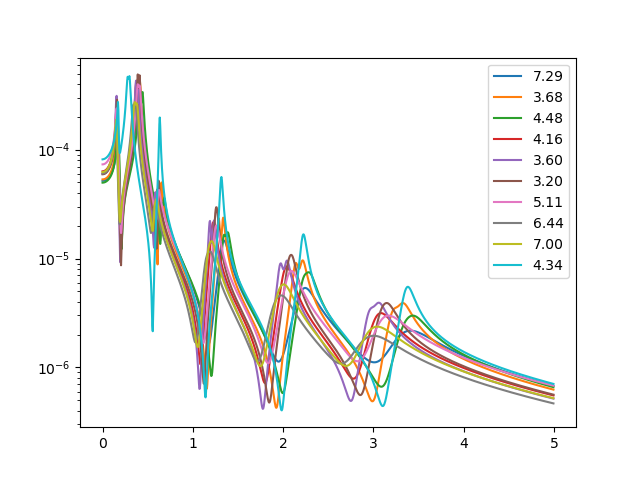

In [109]:
dm_grid = DataManager.from_existing('uq_modal_beam.nc',
                                    os.path.join(result_dir, 'samples'), 
                                    working_dir='/dev/shm/womo1998/')
plt.figure()
with dm_grid.get_database('in') as in_ds:
    for _ in range(10):
        jid=np.random.choice(in_ds.ids)
        savefolder = os.path.join(result_dir, 'samples', jid)
        arr = np.load(os.path.join(savefolder, f'{jid}_mechanical.npz'))
        
        plt.plot(arr['self.omegas']/2/np.pi,np.abs(arr['self.frf'][:,-1]), label=f'{np.mean(arr["self.modal_damping"]*100):1.2f}')
plt.yscale('log')
plt.legend()
# plt.xlim((0,10))
plt.show()